In [195]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
import os
sys.path.append("../") # for importing utils and glm

import utils
from neurofit import utils as nfutils

from corner import corner

# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

write = True



In [196]:
from models import dstrf_mat,cosstrf
reload(utils)

<module 'utils' from '../utils.pyc'>

In [197]:
# load mcmc results
cell = "blublu0809_1_B"
stim_type = "conspecific"

# load mcmc results
folder = "crcns_dstrf_cm"
root = "/scratch/dstrf/results/"
path = "/".join([root,folder,cell,""])

results = {}
for f in next(os.walk(path))[2]:
    name, ext = f.split(".")
    if ext == "npz":
        results[name] = np.load(path+f)
        
#results = [f for f in next(walk(path))[2] if f.split(".")[1] == "npz"]
R = results[results.keys()[0]]
maxlik = R['map']
chain = R['chain']

In [198]:
# dstrf model settings
free_ts = False
scale = 10
channels = 1
ncos = 10
coslin = 1
norm = True
center = True

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample
compress = 1
num_assim_stims = 15


# setup cosine basis
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True,norm=True)

# load data from crcns
stims,durations,spikes_data,spiky_data,names = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress,names=True)
psth_data = [utils.psth_spiky(spk,1,smooth=psth_smooth,dsample=t_dsample) for spk,st in zip(spiky_data,stims)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=psth_smooth) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.52


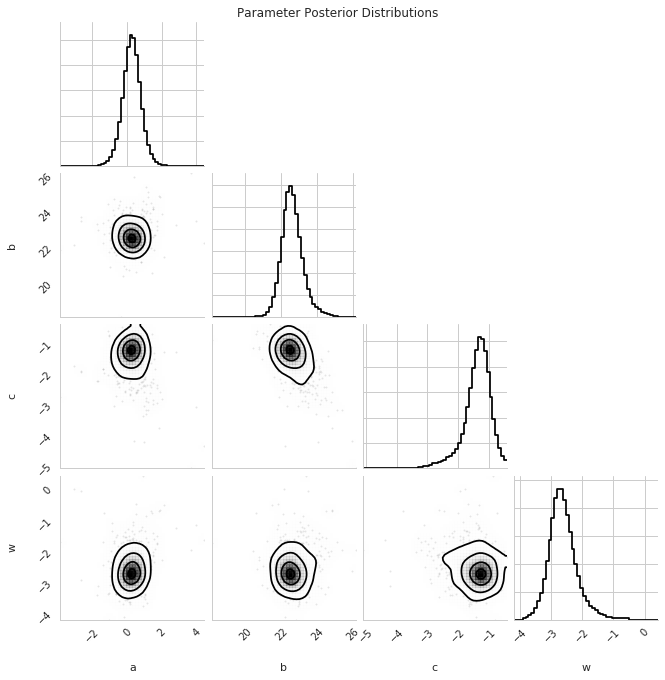

In [199]:
corner(chain[:,-4:],bins=50,
       #truths=maxlik[:4],
       smooth=2,smooth1d=2,
      labels=["a","b","c","w"]);
sns.despine(right=True)
suptitle("Parameter Posterior Distributions")
#savefig("cm_neuron-corner.svg")

In [200]:
import pyspike as pyspk
def dstrf_sample_validate(model,sample,stims,psth,t_dsample=1,psth_smooth=1,sscale=0.1,ntrials=1):
    model.set(sample)

    smpl_corr = []
    psths = []
    thresh = None
    
    for s,p in zip(stims,psth):
        spky = []
        for i in range(ntrials):
            trace, spikes = model.run(s) 
            if np.ndim(trace) > 1: 
                V, thresh = trace.T[:2]
            else: 
                V = trace
            spky.append(pyspk.SpikeTrain(spikes,[0,len(trace)]))
        
        psth = utils.psth_spiky(spky,binres=1,smooth=psth_smooth,dsample=t_dsample)
        #psth -= np.mean(psth)
        #p -= np.mean(p)
        corr = np.corrcoef(psth,p)[0][1]
        smpl_corr.append(corr)
        psths.append(psth)
        
    return smpl_corr, psths

def posterior_predict_corr(model,stims,data,flatchain,t_dsample=1,psth_smooth=1,nsamples=100,bootstrap=False,ntrials=1):
    corrs = []
    psths = []
    
    for s,d in zip(stims,data):
        spks = []
        idx = [None]
        smpl_idx = None
        for i in range(ntrials):
            while smpl_idx in idx:
                smpl_idx = np.random.randint(len(flatchain))
            if not bootstrap: idx.append(smpl_idx)
            smpl = flatchain[smpl_idx]
            model.set(smpl)
            trace, spikes = model.run(s)
            spky = pyspk.SpikeTrain(spikes,[0,len(trace)])
            spks.append(spky)
            
        psth = utils.psth_spiky(spks,1,t_dsample,psth_smooth)
        #psth -= np.mean(psth)
        #d -= np.mean(d)
        corrs.append(np.corrcoef(psth,d)[0][1])     
        psths.append(psth)
    
    return corrs, psths

In [201]:
model = dstrf_mat(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center,stochastic=False)
map_corr, mappsth = dstrf_sample_validate(model,maxlik,test_stims,test_psth,t_dsample,psth_smooth)
ppcorr, pppsth = posterior_predict_corr(model,test_stims,test_psth,chain,t_dsample,psth_smooth,ntrials=100)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)

print("\nMAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))


MAP: 0.59, Dist: 0.66, EO: 0.57
MAP/EO: 1.03, Dist/EO: 1.15


In [202]:
write = False
if write:
    f = open("/".join((root,folder,""))+"results.csv","a+")
    f.write("{},{:.3f},{:.3f}\n".format(cell,corr_means[0],corr_means[1]))
    f.close()

In [203]:
def pploss(predict,data):
    trace,spikes = predict
    lam = trace[:,2]
    print(spikes)
    if np.shape(lam[0]) == ():
        lam = [lam]
        spikes = [data]
    return -np.sum([np.sum(np.log(lam[s])) - np.sum(lam) for s,l in zip(data,lam)])

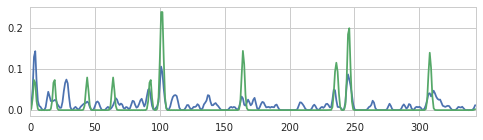

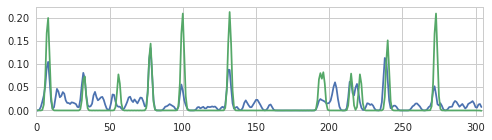

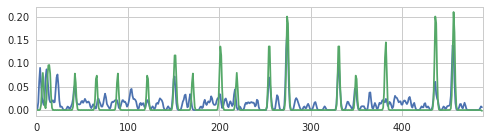

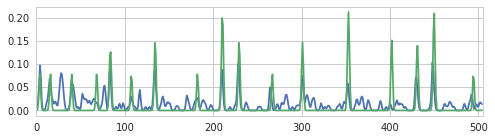

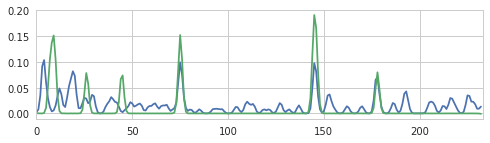

In [204]:
for t, m in zip(test_psth,mappsth):
    figure(figsize=(8,2))
    xlim(0,len(t))
    plot(t)
    plot(m)

In [205]:
from neurofit import graphics
import scipy as sp

In [206]:
from neurofit import graphics
import scipy as sp

lower,upper = sp.stats.norm.interval(0.68,np.mean(chain,0),np.std(chain,0))
idx = []
for i,(l,u) in enumerate(zip(lower,upper)):
    if l < 0 < u and i < nspec + ncos:
        idx.append(i)

clip_chain = chain.copy()
clip_chain[:,idx] *= 0

mu = np.mean(clip_chain,axis=0)
med = np.median(clip_chain,axis=0)

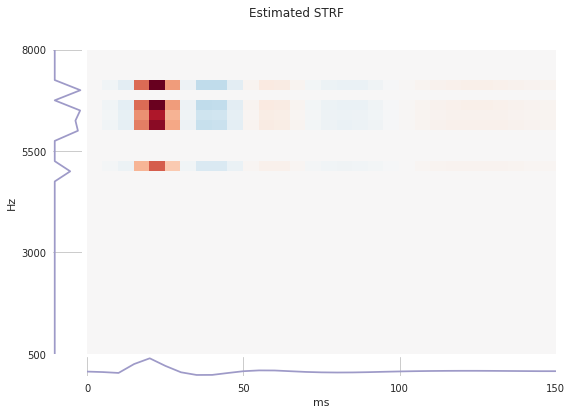

In [207]:
par = cosstrf(channels,nspec,tlen,ncos,coslin,norm,center)
par.set(mu[:-4])

figure(figsize=(9,6))
graphics.strf_plot(par.sfilt,np.hstack(([[0]],par.tfilt))[:,:-1],500,8000,5)
suptitle("Estimated STRF")

In [208]:
figroot = "/scratch/dstrf/figures/crcns_exemplars/" + cell + "/"


rcParams["svg.fonttype"]='none'
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

ch = sns.color_palette("cubehelix",8).as_hex()
ch4 = sns.color_palette("cubehelix",4).as_hex()

rcParams["svg.fonttype"]='none'
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

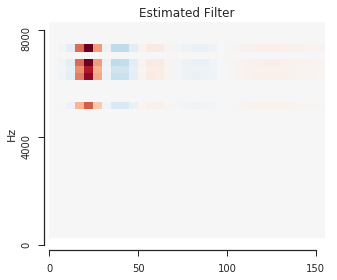

In [209]:
sns.set_style("ticks")

figure(figsize=(5,4))
model.set(np.mean(chain,0))

from neurofit import graphics

par.filt = np.hstack((np.zeros((nspec,1)),par.filt))


#figure()
title("Estimated Filter")
#graphics.strf_plot(M.k.sfilt,M.k.tfilt,0,8000,t_dsample)
sns.heatmap(np.flipud(par.filt),cbar=False)

yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=45);
xticks([0,10,20,30],[0,50,100,150])
ylabel("Hz")


sns.despine(trim=True, offset=5)
tight_layout()

yticks(range(-1,30,15),range(0,8100,int(8000/2)),rotation=90);

savefig(figroot+"mat_strf.svg",bbox_inches='tight')

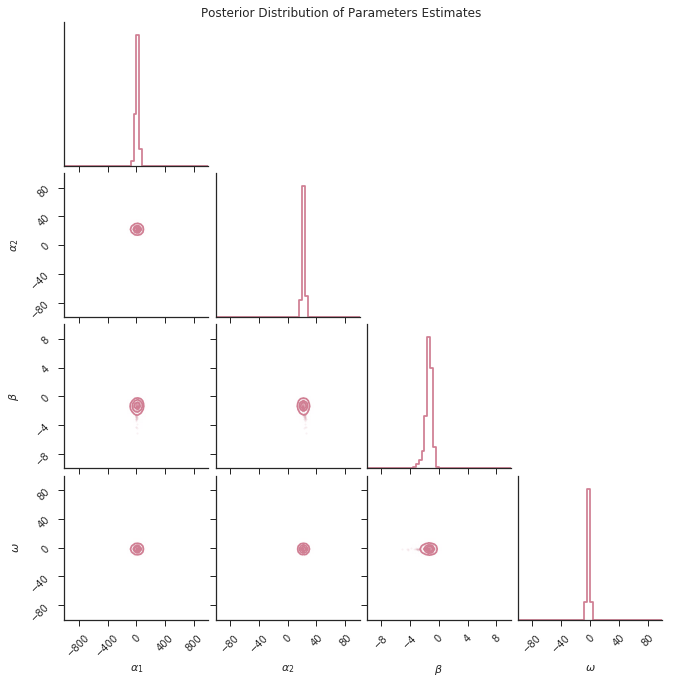

In [210]:
from corner import corner

figure(figsize=(8,8))
sns.set_style("ticks")

matlabs = [r'$\alpha_1$',r'$\alpha_2$',r'$\beta$',r'$\omega$']
c = corner(chain[:,-4:],
       range=[[-1000,1000],
              [-100,100],
              [-10,10],
              [-100,100]],
       bins=50, smooth=1,smooth1d=0.5,
       labels=matlabs,
       #plot_contours=False,
       color=ch4[2],truth_color=ch4[0],max_n_ticks=5)

for i, a in enumerate(c.axes):
    
    if i%5 == 0:
        a.grid(0)
        #sns.despine(left=True)
        a.get_yaxis().set_visible(False)
    else:
        #a.grid()
        sns.despine()
        
suptitle("Posterior Distribution of Parameters Estimates")

        
savefig(figroot+"mat_corner.svg",bbox_inches='tight')

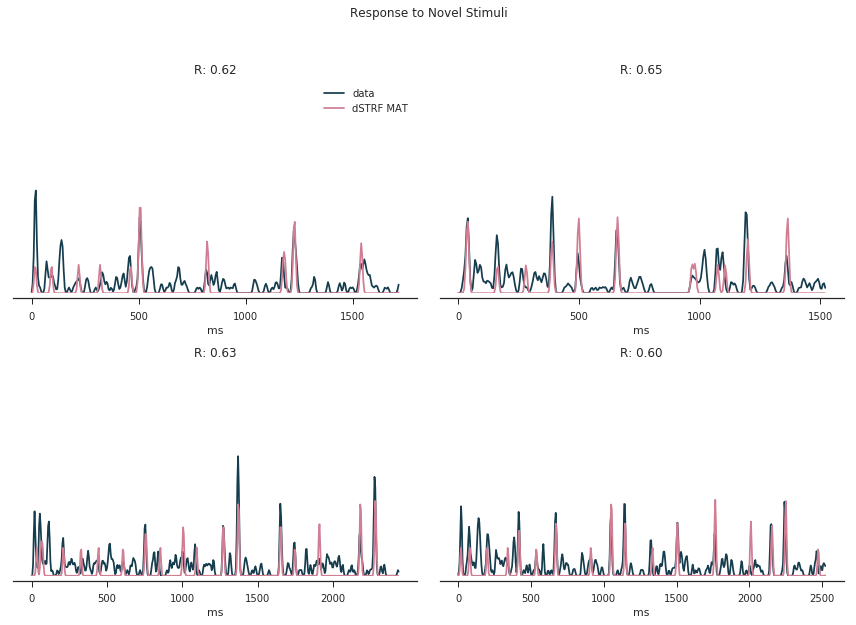

In [211]:
i = 0

figure(figsize=(12,8))

for i in range(4):
    subplot(2,2,i+1)
    dur = len(test_psth[i])*t_dsample
    plot(test_psth[i],ch4[0],label="data")
    plot(mappsth[i]/2,ch4[2],label="dSTRF MAT")
    if i == 0: legend()
    yticks([])
    xlabel("ms")
    ylim(0,0.3)
    xticks(np.arange(0,dur/t_dsample,100),np.arange(0,dur,100*t_dsample))
    title("R: {:.2f}".format(np.corrcoef(test_psth[i],mappsth[i])[0][1]))
tight_layout()
sns.despine(trim=False, left=True, offset=5)
suptitle("Response to Novel Stimuli",y=1.08)

tight_layout()


savefig(figroot+"mat_psth.svg",bbox_inches='tight')